# Problem set 1 - Ph.D. course in Household Finance
## Morteza Aghajanzadeh

## Note:

For this code, I use library programmed by myself, Toolkit.py which has all the functions needed in the model.

In [1]:
import Toolkit as tk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
########## Model Parameters ##########
β = 0.945 ## Discount factor
γ = 2.0 ## Risk Aversion
start = 25 ## starting age
t_w = 40 ## working age
t_r = 35 ## retirement age
T = t_w + t_r ## total periods
λ = 0.6  ## replacement rate
Y_lower = 4.8
rw = 0.02 ## Interest rate when working
rr = 0.02 ## Interest rate when retired
######### Thresholds ##########
vmin = -1.e10


## Income Process Parameters

In [3]:
########## Income Process Parameters ##########
## Trend
g_t = pd.read_excel('Income_profile.xlsx')['Y'].to_numpy().flatten() ## Income profile
# trend_pension = λ * g_t[t_w-1]

## Permanent Income Process
N_z = 15  ## number of states for the permanent income process
μ_z = 0.0 ## mean of the permanent income process
ρ_z = 1 ## persistence of the permanent income process
σ_η = 0.015   ## standard deviation of the permanent income process
Z,π_z = tk.tauchenhussey(N_z, μ_z, ρ_z, σ_η)
Z = np.exp(Z)[0].reshape(N_z,1) ## permanent income process

## Transitory Income Process
N_ω = 5 ## number of states for the transitory income process
μ_ω = 0.0 ## mean of the transitory income process
ρ_ω = 0 ## iid process
σ_ω = 0.1  ## standard deviation of the transitory income process
ω,π_ω = tk.tauchenhussey(N_ω, μ_ω, ρ_ω, σ_ω)
ω = np.exp(ω)[0].reshape(N_ω,1) ## transitory income process

π = np.kron(π_z, π_ω) ## transition matrix for the income process

π.shape

(75, 75)

## Simulation Parameters

In [4]:
########## Simulation Parameters ##########
set_seed = 13990509
np.random.seed(set_seed)
N = 1000
μ_A = 1.916 
σ_A = 2.129
A = np.random.normal(μ_A - σ_A**2 / 2, σ_A, N)
A = np.exp(A)
A[A < 0] = 0

μ_z = 0.0
σ_z = 0.015
Z0 = np.exp(np.random.normal(μ_z - σ_z**2 / 2 , σ_z, N))
ε_z = np.random.normal(-σ_z**2/2, σ_z, (N,T))

μ_ω = 0.0
W0 = np.exp(np.random.normal(μ_ω - σ_ω**2 / 2 , σ_ω, N))
ε_ω = np.exp(np.random.normal(μ_ω-σ_ω**2, σ_ω, (N,T)))



######### Thresholds ##########
vmin = -1.e10

## Creating Asset Grid

In [10]:
########## Asset Grid ##########
a_max = 1000 ## upper bound of the grid for assets
ϕ = 0  ## Borrowing Constraint
N_a = 200 ## number of grid points for assets
# a_grid = np.linspace(ϕ, a_max, N_a).reshape(N_a,1) ## linear grid for assets
a_grid = tk.discretize_assets_single_exp(ϕ, a_max, N_a).reshape(N_a,1) ## double exponential grid for assets

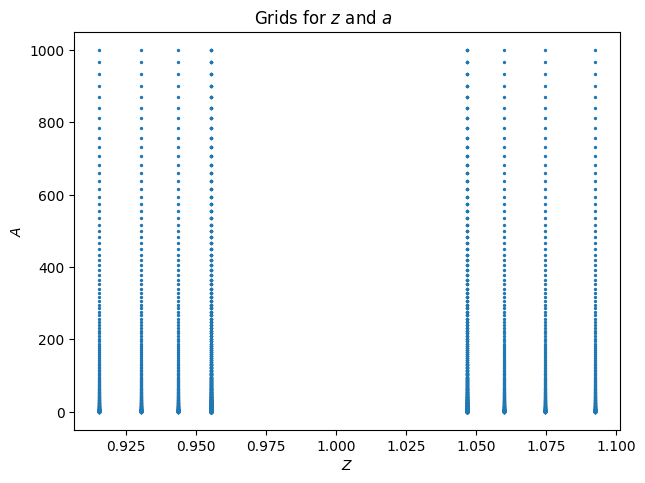

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

s_grid,a_grid_2 = np.meshgrid(Z,a_grid,indexing='ij')
ax.scatter(s_grid,a_grid_2,2)

ax.set_yscale('linear')
ax.set_xlabel('$Z$')
ax.set_ylabel('$A$')

fig.suptitle('Grids for $z$ and $a$')
fig.tight_layout(pad=0.5)

## Retirement Problem

In the retirement period, there is no uncertainty about the future so the HH's problem is
$$
\max_{A_t}\quad u(X_t - A_t) + \beta V(A_{t+1})
$$

In [12]:
Vr, Cr, Xr = tk.retirement(N_a,a_grid, rr, β, γ, t_r, t_w, g_t, λ,vmin)
# Vr is the value function for retirement
# Cr is the consumption function for retirement
print(Vr.shape, Cr.shape, Xr.shape)

(201, 35) (201, 35) (201, 35)


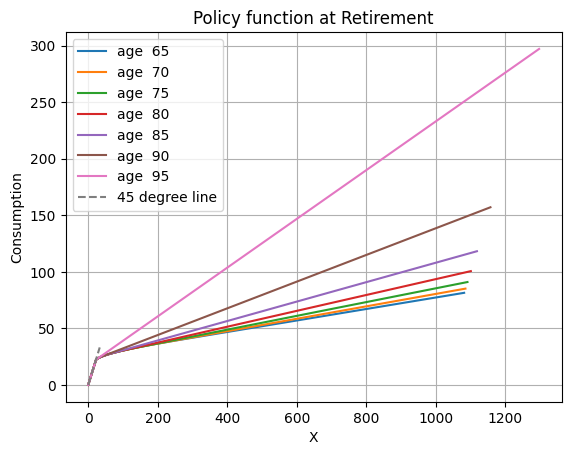

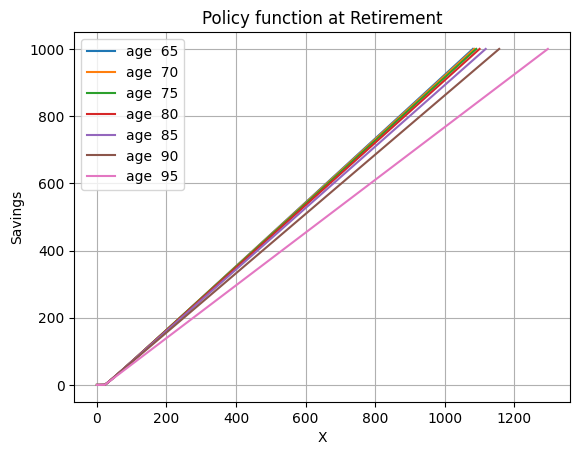

In [13]:
tk.plot_policy_over_ages(Xr,Cr,t_r,'Retirement', N_a, start, t_w,line45=True, yaxis='Consumption')
Sr = Xr - Cr
tk.plot_policy_over_ages(Xr,Sr,t_r,'Retirement', N_a, start, t_w,line45=False, yaxis='Savings')


## Working problem

HH's problem is
$$
\max_{A_t}\quad u(X_t - A_t) + \beta E{[V(A_{t+1})]}
$$

In [14]:
Vw, Cw, Xw = tk.working(N_z, N_ω, N_a, a_grid, Z, ω, π, rw, rr, Xr, Cr, Vr, β, γ, t_w, g_t,λ,vmin)
# Vw is the value function for working
# Cw is the consumption function for working
print(Vw.shape, Cw.shape, Xw.shape)

(3015, 40) (3015, 40) (3015, 40)


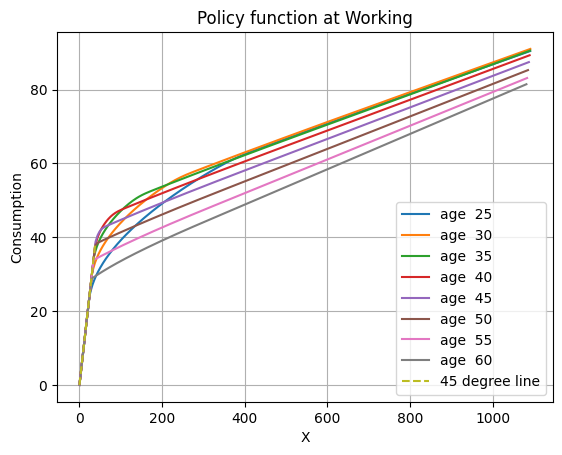

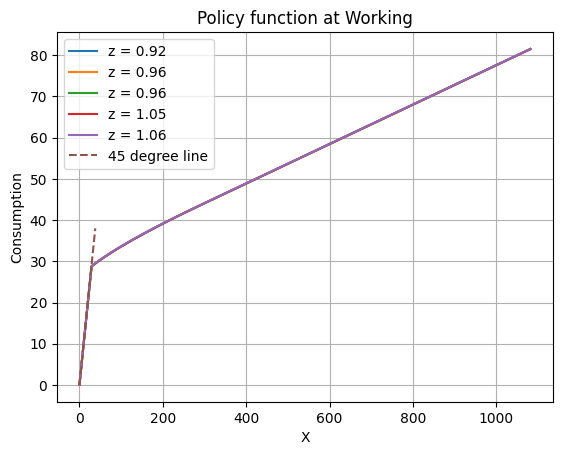

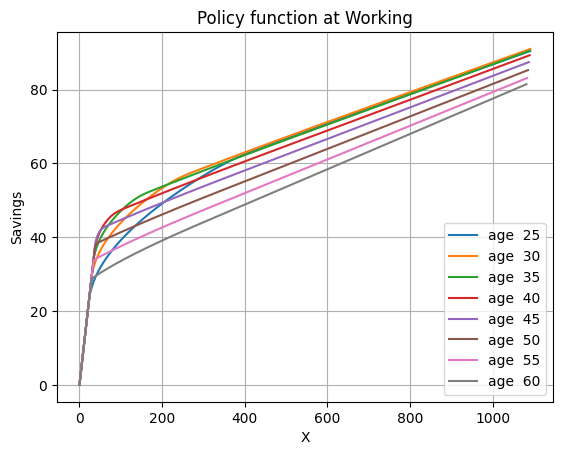

In [15]:
tk.plot_policy_over_ages(Xw,Cw,t_w,'Working', N_a, start, 0,line45=True, yaxis='Consumption')
tk.plot_policy_over_states(Xw,Cw,Z,20,t_w,start,N_z,N_a,line45=True,yaxis='Consumption')
Sw = Xw - Cw
tk.plot_policy_over_ages(Xw,Cw,t_w,'Working', N_a, start, 0,line45=False, yaxis='Savings')

## Simulation

Simulated model for working age
Simulated model for retirement age


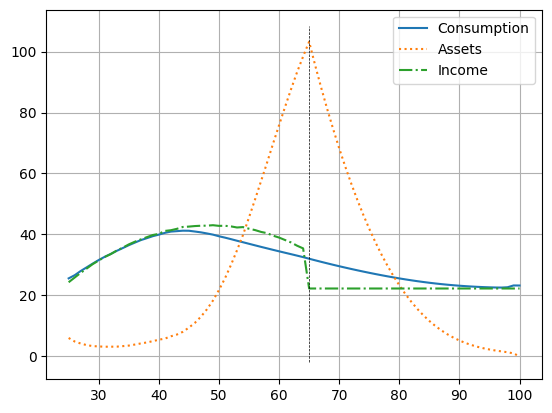

In [16]:
A_sim, Z_sim, ω_sim, income_sim, Zi_sim, X_sim, C_sim =  tk.simulate_model(T, rw, rr, Xw, Cw, Y_lower, t_w, t_r, g_t, ρ_z, N, N_a, Xr, Cr, Z, λ, ε_z, ε_ω, A, Z0,start)

Simulated model for working age
Simulated model for retirement age


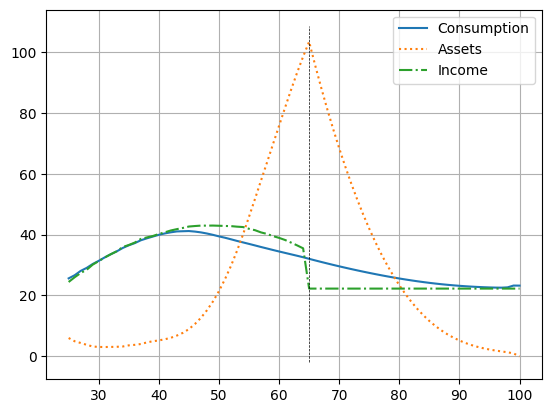

In [12]:
Vr, Cr, Xr, Vw, Cw, Xw, A_sim, Z_sim, ω_sim, income_sim, Zi_sim, X_sim, C_sim = tk.gen_results(T,β,γ,start,t_w,t_r,λ,rw,rr,N_z,μ_z,ρ_z,σ_η,N_ω,μ_ω,ρ_ω,σ_ω,N_a,a_max,ϕ,N,μ_A,σ_A,Y_lower,σ_z,g_t,plot = True)